<a href="https://colab.research.google.com/github/AkshayKohad/Transformer-English-French-translation/blob/main/Transformer_Architecture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

akshaykohad_ted_talks_corpus_path = kagglehub.dataset_download('akshaykohad/ted-talks-corpus')

print('Data source import complete.')


In this notebook, I train a transformer model for translating English to French. The model structure is the same as that of the original [Attention Is All You Need](https://arxiv.org/pdf/1706.03762.pdf) paper.

In [ ]:
!pip install sentencepiece --quiet
!pip install sacrebleu --quiet
!pip install torchdata --quiet
!pip install torchtext --quiet

In [ ]:
import math
from dataclasses import dataclass

import numpy as np
import sacrebleu
import sentencepiece as spm
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from tqdm import tqdm

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


In [ ]:
def read_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        return [line.strip() for line in file.readlines()]

# File paths
train_en_path = '/kaggle/input/ted-talks-corpus/ted-talks-corpus/train.en'
test_en_path = '/kaggle/input/ted-talks-corpus/ted-talks-corpus/test.en'
train_fr_path = '/kaggle/input/ted-talks-corpus/ted-talks-corpus/train.fr'
test_fr_path = '/kaggle/input/ted-talks-corpus/ted-talks-corpus/test.fr'
dev_en_path = '/kaggle/input/ted-talks-corpus/ted-talks-corpus/dev.en'
dev_fr_path = '/kaggle/input/ted-talks-corpus/ted-talks-corpus/dev.fr'
# Read the data
train_en = read_file(train_en_path)
test_en = read_file(test_en_path)
train_fr = read_file(train_fr_path)
test_fr = read_file(test_fr_path)
dev_en = read_file(dev_en_path)
dev_fr = read_file(dev_fr_path)
# Store the data in a dictionary
data = {
    'train': {
        'en': train_en,
        'fr': train_fr
    },
    'test': {
        'en': test_en,
        'fr': test_fr
    },
    'dev':{
        'en': dev_en,
        'fr': dev_fr
    }

}

# Example: Accessing the data
print("Number of training English sentences:", len(data['train']['en']))
print("First training English sentence:", data['train']['en'][0])
print("First training English sentence:", data['train']['fr'][0])


Number of training English sentences: 30000
First training English sentence: David Gallo: This is Bill Lange. I'm Dave Gallo.
First training English sentence: David Gallo: Voici Bill Lange. Je suis Dave Gallo.


# Get English and french tokenizers from SentencePiece

In [ ]:
en_vocab_size = 10000
fr_vocab_size = 8000
vocab_sizes = {"en": en_vocab_size, "fr": fr_vocab_size}

In [ ]:
# Train SentencePiece models
spm.SentencePieceTrainer.train(
    f'--input={train_en_path} --model_prefix=train_en --vocab_size={en_vocab_size} --user_defined_symbols=<pad>'
)
spm.SentencePieceTrainer.train(
    f'--input={train_fr_path} --model_prefix=train_fr --vocab_size={fr_vocab_size} --user_defined_symbols=<pad>'
)

# Load the SentencePiece models
en_sp = spm.SentencePieceProcessor()
en_sp.load('train_en.model')

fr_sp = spm.SentencePieceProcessor()
fr_sp.load('train_fr.model')

# Example: Encoding and decoding with the SentencePiece models
# Encoding: text to IDs
sample_sentence_en = "This is a test"
sample_sentence_fr = "Ceci est un test"

tokenized_en = en_sp.encode_as_ids(sample_sentence_en)
tokenized_fr = fr_sp.encode_as_ids(sample_sentence_fr)

print("Tokenized English:", tokenized_en)
print("Tokenized French:", tokenized_fr)

# Decoding: IDs to text
decoded_en = en_sp.decode_ids(tokenized_en)
decoded_fr = fr_sp.decode_ids(tokenized_fr)

print("Decoded English:", decoded_en)
print("Decoded French:", decoded_fr)

Tokenized English: [103, 16, 11, 774]
Tokenized French: [660, 33, 19, 1139]
Decoded English: This is a test
Decoded French: Ceci est un test


sentencepiece_trainer.cc(178) LOG(INFO) Running command: --input=/kaggle/input/ted-talks-corpus/ted-talks-corpus/train.en --model_prefix=train_en --vocab_size=10000 --user_defined_symbols=<pad>
sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: /kaggle/input/ted-talks-corpus/ted-talks-corpus/train.en
  input_format: 
  model_prefix: train_en
  model_type: UNIGRAM
  vocab_size: 10000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  user_defined_symbols: <pad>
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremel

In [ ]:
# indexes of special symbols
UNK, BOS, EOS, PAD = 0, 1, 2, 3

# Data processing

In [ ]:
train_set = [(x.rstrip('\n'), y.rstrip('\n')) for x, y in zip(data['train']['en'], data['train']['fr']) if x != '']
valid_set = [(x.rstrip('\n'), y.rstrip('\n')) for x, y in zip(data['dev']['en'],data['dev']['fr']) if x!='']
test_set  = [(x.rstrip('\n'), y.rstrip('\n')) for x, y in zip(data['test']['en'],data['test']['fr']) if x!='']
print(len(train_set), len(valid_set), len(test_set))


30000 887 1305


In [ ]:
max_seq_len = 50
# Tokenization with BOS and EOS
def tokenize_with_bos_eos(sp, sentence):
    tokenized = sp.encode_as_ids(sentence)[0:max_seq_len-2]
    return [BOS] + tokenized + [EOS]

# Create tokenized datasets with BOS and EOS
train_set = [(tokenize_with_bos_eos(en_sp, x), tokenize_with_bos_eos(fr_sp, y))
             for x, y in zip(data['train']['en'], data['train']['fr']) if x != '']
valid_set = [(tokenize_with_bos_eos(en_sp, x), tokenize_with_bos_eos(fr_sp, y))
             for x, y in zip(data['dev']['en'], data['dev']['fr']) if x != '']
test_set = [(tokenize_with_bos_eos(en_sp, x), tokenize_with_bos_eos(fr_sp, y))
            for x, y in zip(data['test']['en'], data['test']['fr']) if x != '']

# en_sp.encode_as_ids

# def tokenize_dataset(dataset):
#     'tokenize a dataset and add [BOS] and [EOS] to the beginning and end of the sentences'
#     return [(torch.tensor([BOS]+tokenizers[SRC](src_text)[0:max_seq_len-2]+[EOS]),
#              torch.tensor([BOS]+tokenizers[TRG](trg_text)[0:max_seq_len-2]+[EOS]))
#             for src_text, trg_text in dataset]

# train_tokenized = tokenize_dataset(train_set)
# valid_tokenized = tokenize_dataset(valid_set)
# test_tokenized  = tokenize_dataset(test_set)

In [ ]:
import torch
from torch.utils.data import Dataset

class TranslationDataset(Dataset):
    """Create a dataset for torch.utils.data.DataLoader() for translation tasks."""

    def __init__(self, data, en_tokenizer, fr_tokenizer):
        self.data = data
        self.en_tokenizer = en_tokenizer
        self.fr_tokenizer = fr_tokenizer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Retrieve the source and target sentences
        src, trg = self.data[idx]

        # Tokenize and add special tokens
        src_tokens = src #[BOS] + self.en_tokenizer.encode_as_ids(src) + [EOS]
        trg_tokens = trg #[BOS] + self.fr_tokenizer.encode_as_ids(trg) + [EOS]

        # Convert to PyTorch tensors
        src_tensor = torch.tensor(src_tokens, dtype=torch.long)
        trg_tensor = torch.tensor(trg_tokens, dtype=torch.long)

        return src_tensor, trg_tensor

def pad_sequence(batch):
    """Collate function for padding sentences such that all sentences in the batch have the same length."""
    src_seqs = [src for src, trg in batch]
    trg_seqs = [trg for src, trg in batch]

    # Pad the source and target sequences
    src_padded = torch.nn.utils.rnn.pad_sequence(src_seqs, batch_first=True, padding_value=PAD)
    trg_padded = torch.nn.utils.rnn.pad_sequence(trg_seqs, batch_first=True, padding_value=PAD)

    return src_padded, trg_padded

# Create the datasets
# train_set = [(x.rstrip('\n'), y.rstrip('\n')) for x, y in zip(data['train']['en'], data['train']['fr']) if x != '']
# valid_set = [(x.rstrip('\n'), y.rstrip('\n')) for x, y in zip(data['dev']['en'], data['dev']['fr']) if x != '']
# test_set  = [(x.rstrip('\n'), y.rstrip('\n')) for x, y in zip(data['test']['en'], data['test']['fr']) if x != '']

# # Instantiate the TranslationDataset
# train_dataset = TranslationDataset(train_set, en_sp, fr_sp)
# valid_dataset = TranslationDataset(valid_set, en_sp, fr_sp)
# test_dataset = TranslationDataset(test_set, en_sp, fr_sp)

# Check lengths of datasets
# print(len(train_dataset))
# print(len(valid_dataset))
# print(len(test_dataset))

# Example of accessing an item
# print("Sample from train dataset:", train_dataset[0])


In [ ]:
batch_size = 128

class Dataloaders:
    """Dataloaders contains train_loader, test_loader, and valid_loader for training and evaluation."""

    def __init__(self, train_set, valid_set, test_set, en_tokenizer, fr_tokenizer):
        # Initialize datasets
        self.train_dataset = TranslationDataset(train_set, en_tokenizer, fr_tokenizer)
        self.valid_dataset = TranslationDataset(valid_set, en_tokenizer, fr_tokenizer)
        self.test_dataset  = TranslationDataset(test_set, en_tokenizer, fr_tokenizer)

        # Create DataLoaders for each dataset
        self.train_loader = torch.utils.data.DataLoader(self.train_dataset,
                                                         batch_size=batch_size,
                                                         shuffle=True,
                                                         collate_fn=pad_sequence)

        self.valid_loader = torch.utils.data.DataLoader(self.valid_dataset,
                                                         batch_size=batch_size,
                                                         shuffle=False,
                                                         collate_fn=pad_sequence)

        self.test_loader = torch.utils.data.DataLoader(self.test_dataset,
                                                        batch_size=batch_size,
                                                        shuffle=False,
                                                        collate_fn=pad_sequence)

# Instantiate the Dataloaders
dataloaders = Dataloaders(train_set, valid_set, test_set, en_sp, fr_sp)

# Example usage: Check lengths of each DataLoader
print("Number of batches in train loader:", len(dataloaders.train_loader))
print("Number of batches in valid loader:", len(dataloaders.valid_loader))
print("Number of batches in test loader:", len(dataloaders.test_loader))

# Example of accessing a batch from the train loader
for src, trg in dataloaders.train_loader:
    print("Source batch shape:", src.shape)
    print("Target batch shape:", trg.shape)
    break  # Remove this break to see more batches


Number of batches in train loader: 235
Number of batches in valid loader: 7
Number of batches in test loader: 11
Source batch shape: torch.Size([128, 50])
Target batch shape: torch.Size([128, 50])


# Transformer Model

In [ ]:
import torch
import torch.nn as nn
import math

class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_embed, dropout=0.0):
        super(MultiHeadedAttention, self).__init__()
        assert d_embed % h == 0, "Embedding dimension must be divisible by number of heads."
        self.d_k = d_embed // h  # Dimension of each head
        self.d_embed = d_embed
        self.h = h

        # Linear layers for query, key, and value projections
        self.WQ = nn.Linear(d_embed, d_embed)
        self.WK = nn.Linear(d_embed, d_embed)
        self.WV = nn.Linear(d_embed, d_embed)

        # Final linear layer
        self.linear = nn.Linear(d_embed, d_embed)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x_query, x_key, x_value, mask=None):
        nbatch = x_query.size(0)  # Get batch size

        # Linear projections and reshape for multi-head attention
        query = self.WQ(x_query).view(nbatch, -1, self.h, self.d_k).transpose(1, 2)
        key = self.WK(x_key).view(nbatch, -1, self.h, self.d_k).transpose(1, 2)
        value = self.WV(x_value).view(nbatch, -1, self.h, self.d_k).transpose(1, 2)

        # Compute attention scores
        scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(self.d_k)

        # Apply mask if provided
        if mask is not None:
            scores = scores.masked_fill(mask, float('-inf'))

        # Softmax to get attention weights
        p_atten = torch.nn.functional.softmax(scores, dim=-1)
        p_atten = self.dropout(p_atten)

        # Compute the output as a weighted sum of the values
        x = torch.matmul(p_atten, value)

        # Concatenate the heads and pass through final linear layer
        x = x.transpose(1, 2).contiguous().view(nbatch, -1, self.d_embed)
        return self.linear(x)  # Final output

# Example of how to instantiate and use the MultiHeadedAttention class
if __name__ == "__main__":
    # Parameters
    h = 8  # Number of attention heads
    d_embed = 512  # Embedding dimension
    batch_size = 32  # Example batch size
    seq_len = 50  # Example sequence length

    # Create an instance of MultiHeadedAttention
    mha = MultiHeadedAttention(h, d_embed)

    # Example input tensors
    x_query = torch.randn(batch_size, seq_len, d_embed)  # Shape: (batch_size, seq_len, d_embed)
    x_key = torch.randn(batch_size, seq_len, d_embed)
    x_value = torch.randn(batch_size, seq_len, d_embed)

    # Forward pass
    output = mha(x_query, x_key, x_value)
    print("Output shape:", output.shape)  # Should be (batch_size, seq_len, d_embed)


Output shape: torch.Size([32, 50, 512])


In [ ]:
import torch
import torch.nn as nn

class ResidualConnection(nn.Module):
    """Residual connection: x + dropout(sublayer(layernorm(x)))"""

    def __init__(self, dim, dropout):
        super().__init__()
        self.drop = nn.Dropout(dropout)
        self.norm = nn.LayerNorm(dim)

    def forward(self, x, sublayer):
        """Applies the residual connection with a given sublayer."""
        return x + self.drop(sublayer(self.norm(x)))

# Example of how to use the ResidualConnection class
if __name__ == "__main__":
    # Parameters
    dim = 256  # Example embedding dimension
    dropout_rate = 0.1  # Example dropout rate

    # Create an instance of ResidualConnection
    residual_connection = ResidualConnection(dim, dropout_rate)

    # Example input tensor
    x = torch.randn(32, 50, dim)  # Shape: (batch_size, seq_len, dim)

    # Example sublayer (simple feedforward layer for demonstration)
    class SimpleSublayer(nn.Module):
        def __init__(self, dim):
            super().__init__()
            self.linear = nn.Linear(dim, dim)

        def forward(self, x):
            return self.linear(x)

    # Instantiate a simple sublayer
    sublayer = SimpleSublayer(dim)

    # Forward pass through the residual connection
    output = residual_connection(x, sublayer)
    print("Output shape:", output.shape)  # Should be (batch_size, seq_len, dim)


Output shape: torch.Size([32, 50, 256])


In [ ]:
import torch
import torch.nn as nn

class Encoder(nn.Module):
    """Encoder = token embedding + positional embedding -> a stack of N EncoderBlocks -> layer norm"""

    def __init__(self, config):
        super().__init__()
        self.d_embed = config.d_embed
        self.tok_embed = nn.Embedding(config.encoder_vocab_size, self.d_embed)
        self.pos_embed = nn.Parameter(torch.zeros(1, config.max_seq_len, self.d_embed))
        self.encoder_blocks = nn.ModuleList([EncoderBlock(config) for _ in range(config.N_encoder)])
        self.dropout = nn.Dropout(config.dropout)
        self.norm = nn.LayerNorm(self.d_embed)

    def forward(self, input, mask=None):
        # Token and positional embeddings
        x = self.tok_embed(input)
        x_pos = self.pos_embed[:, :x.size(1), :]
        x = self.dropout(x + x_pos)

        # Pass through each encoder block
        for layer in self.encoder_blocks:
            x = layer(x, mask)

        return self.norm(x)

class EncoderBlock(nn.Module):
    """EncoderBlock: self-attention -> position-wise fully connected feed-forward layer"""

    def __init__(self, config):
        super(EncoderBlock, self).__init__()
        self.atten = MultiHeadedAttention(config.h, config.d_embed, config.dropout)
        self.feed_forward = nn.Sequential(
            nn.Linear(config.d_embed, config.d_ff),
            nn.ReLU(),
            nn.Dropout(config.dropout),
            nn.Linear(config.d_ff, config.d_embed)
        )
        self.residual1 = ResidualConnection(config.d_embed, config.dropout)
        self.residual2 = ResidualConnection(config.d_embed, config.dropout)

    def forward(self, x, mask=None):
        # Self-attention with residual connection
        x = self.residual1(x, lambda x: self.atten(x, x, x, mask=mask))
        # Feed-forward layer with residual connection
        return self.residual2(x, self.feed_forward)

# Example Config Class for Encoder
class Config:
    def __init__(self):
        self.d_embed = 512       # Embedding dimension
        self.encoder_vocab_size = 10000  # Size of the encoder vocabulary
        self.max_seq_len = 50    # Maximum sequence length
        self.N_encoder = 6       # Number of encoder blocks
        self.dropout = 0.1       # Dropout rate
        self.d_ff = 512          # Dimension of the feed-forward layer
        self.h = 8               # Number of attention heads

# Example of how to instantiate and use the Encoder
if __name__ == "__main__":
    config = Config()
    encoder = Encoder(config)

    # Example input tensor (batch_size, seq_len)
    input_tensor = torch.randint(0, config.encoder_vocab_size, (32, config.max_seq_len))  # Random input
    mask = None  # Placeholder for a potential mask

    # Forward pass
    output = encoder(input_tensor, mask)
    print("Encoder output shape:", output.shape)  # Should be (batch_size, seq_len, d_embed)


Encoder output shape: torch.Size([32, 50, 512])


In [ ]:
import torch
import torch.nn as nn

class Decoder(nn.Module):
    """Decoder = token embedding + positional embedding -> a stack of N DecoderBlocks -> fully-connected layer"""

    def __init__(self, config):
        super().__init__()
        self.d_embed = config.d_embed
        self.tok_embed = nn.Embedding(config.decoder_vocab_size, self.d_embed)
        self.pos_embed = nn.Parameter(torch.zeros(1, config.max_seq_len, self.d_embed))
        self.dropout = nn.Dropout(config.dropout)
        self.decoder_blocks = nn.ModuleList([DecoderBlock(config) for _ in range(config.N_decoder)])
        self.norm = nn.LayerNorm(self.d_embed)
        self.linear = nn.Linear(self.d_embed, config.decoder_vocab_size)

    def future_mask(self, seq_len):
        """Mask out tokens at future positions"""
        mask = (torch.triu(torch.ones(seq_len, seq_len, requires_grad=False), diagonal=1) != 0).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
        return mask.view(1, 1, seq_len, seq_len)

    def forward(self, memory, src_mask, trg, trg_pad_mask):
        seq_len = trg.size(1)
        trg_mask = torch.logical_or(trg_pad_mask, self.future_mask(seq_len))
        x = self.tok_embed(trg) + self.pos_embed[:, :trg.size(1), :]
        x = self.dropout(x)

        for layer in self.decoder_blocks:
            x = layer(memory, src_mask, x, trg_mask)

        x = self.norm(x)
        logits = self.linear(x)
        return logits

class DecoderBlock(nn.Module):
    """DecoderBlock: self-attention -> position-wise feed-forward layer"""

    def __init__(self, config):
        super().__init__()
        self.atten1 = MultiHeadedAttention(config.h, config.d_embed)  # Self-attention
        self.atten2 = MultiHeadedAttention(config.h, config.d_embed)  # Cross-attention
        self.feed_forward = nn.Sequential(
            nn.Linear(config.d_embed, config.d_ff),
            nn.ReLU(),
            nn.Dropout(config.dropout),
            nn.Linear(config.d_ff, config.d_embed)
        )
        self.residuals = nn.ModuleList([ResidualConnection(config.d_embed, config.dropout) for _ in range(3)])

    def forward(self, memory, src_mask, decoder_layer_input, trg_mask):
        # Self-attention
        y = self.residuals[0](decoder_layer_input, lambda y: self.atten1(y, y, y, mask=trg_mask))
        # Cross-attention
        y = self.residuals[1](y, lambda y: self.atten2(y, memory, memory, mask=src_mask))
        # Feed-forward layer
        return self.residuals[2](y, self.feed_forward)


In [ ]:

class Transformer(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, src, src_mask, trg, trg_pad_mask):
        return self.decoder(self.encoder(src, src_mask), src_mask, trg, trg_pad_mask)

In [ ]:
from dataclasses import dataclass

@dataclass
class ModelConfig:
    encoder_vocab_size: int
    decoder_vocab_size: int
    d_embed: int
    d_ff: int
    h: int
    N_encoder: int
    N_decoder: int
    max_seq_len: int
    dropout: float

def make_model(config):
    model = Transformer(Encoder(config), Decoder(config)).to(DEVICE)

    # Initialize model parameters
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)

    return model

# Example of how to instantiate ModelConfig and create the model
if __name__ == "__main__":
    config = ModelConfig(
        encoder_vocab_size=10000,
        decoder_vocab_size=8000,
        d_embed=512,
        d_ff=512,
        h=8,
        N_encoder=6,
        N_decoder=6,
        max_seq_len=50,
        dropout=0.1
    )

    model = make_model(config)
    print("Model created with configuration:", config)


Model created with configuration: ModelConfig(encoder_vocab_size=10000, decoder_vocab_size=8000, d_embed=512, d_ff=512, h=8, N_encoder=6, N_decoder=6, max_seq_len=50, dropout=0.1)


# Training and evaluation helper functions

In [ ]:
def make_batch_input(src, trg):
    """
    Prepares the input for the model during training.

    Args:
        src: Source tensor (batch_size, src_seq_len).
        trg: Target tensor (batch_size, trg_seq_len).

    Returns:
        src: Tensor of source sequences (moved to DEVICE).
        trg_in: Target input tensor (moved to DEVICE, excluding the last token).
        trg_out: Target output tensor (moved to DEVICE, excluding the first token).
        src_pad_mask: Padding mask for the source sequences.
        trg_pad_mask: Padding mask for the target input sequences.
    """
    # Move tensors to the specified device
    src = src.to(DEVICE)
    trg_in = trg[:, :-1].to(DEVICE)  # Exclude the last token for input
    trg_out = trg[:, 1:].contiguous().view(-1).to(DEVICE)  # Exclude the first token for output

    # Create padding masks
    src_pad_mask = (src == PAD).view(src.size(0), 1, 1, src.size(1))  # Shape: (batch_size, 1, 1, src_seq_len)
    trg_pad_mask = (trg_in == PAD).view(trg_in.size(0), 1, 1, trg_in.size(1))  # Shape: (batch_size, 1, 1, trg_seq_len)

    return src, trg_in, trg_out, src_pad_mask, trg_pad_mask


In [ ]:
def make_batch_input(x, y):
        src = x.to(DEVICE)
        trg_in = y[:, :-1].to(DEVICE)
        trg_out = y[:, 1:].contiguous().view(-1).to(DEVICE)
        src_pad_mask = (src == PAD).view(src.size(0), 1, 1, src.size(-1))
        trg_pad_mask = (trg_in == PAD).view(trg_in.size(0), 1, 1, trg_in.size(-1))
        return src, trg_in, trg_out, src_pad_mask, trg_pad_mask

In [ ]:
import numpy as np
import torch
from tqdm import tqdm

def train_epoch(model, dataloaders, optimizer, loss_fn, scheduler, device):
    model.train()
    grad_norm_clip = 1.0
    losses, acc, count = [], 0, 0
    num_batches = len(dataloaders.train_loader)

    pbar = tqdm(enumerate(dataloaders.train_loader), total=num_batches)
    for idx, (src, trg) in pbar:
        optimizer.zero_grad()

        # Prepare the inputs and targets
        src, trg_in, trg_out, src_pad_mask, trg_pad_mask = make_batch_input(src, trg)

        # Forward pass
        pred = model(src, src_pad_mask, trg_in, trg_pad_mask).to(device)

        # Reshape predictions for loss computation
        pred = pred.view(-1, pred.size(-1))

        # Compute loss
        loss = loss_fn(pred, trg_out).to(device)
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_norm_clip)

        # Optimizer step
        optimizer.step()
        scheduler.step()

        # Store the loss
        losses.append(loss.item())

        # Report progress every 50 batches
        if idx > 0 and idx % 50 == 0:
            pbar.set_description(f'train loss={loss.item():.3f}, lr={scheduler.get_last_lr()[0]:.5f}')

    return np.mean(losses)


In [ ]:
def train(model, dataloaders, epochs, optimizer, loss_fn, scheduler, device, early_stop_count=5):
    """Train the model and validate after each epoch."""
    best_valid_loss = float('inf')
    for ep in range(epochs):
        train_loss = train_epoch(model, dataloaders, optimizer, loss_fn, scheduler, device)
        valid_loss = validate(model, dataloaders.valid_loader, loss_fn, device)

        print(f'Epoch {ep + 1}: train_loss={train_loss:.5f}, valid_loss={valid_loss:.5f}')

        # Check for improvement in validation loss
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            early_stop_count = 5  # Reset early stopping counter
            # You might want to save the model here
            # torch.save(model.state_dict(), 'best_model.pth')
        else:
            early_stop_count -= 1
            if early_stop_count <= 0:
                print("Early stopping triggered.")
                break  # Stop training if validation loss hasn't improved

    return train_loss, valid_loss


In [ ]:
def validate(model, dataloader, loss_fn, device):
    """Compute the validation loss."""
    model.eval()  # Set the model to evaluation mode
    losses = []

    with torch.no_grad():  # Disable gradient calculation
        for x, y in dataloader:
            # Prepare the inputs and targets
            src, trg_in, trg_out, src_pad_mask, trg_pad_mask = make_batch_input(x, y)

            # Forward pass
            pred = model(src, src_pad_mask, trg_in, trg_pad_mask).to(device)

            # Reshape predictions for loss computation
            pred = pred.view(-1, pred.size(-1))

            # Compute loss and store it
            loss = loss_fn(pred, trg_out).item()
            losses.append(loss)

    return np.mean(losses)  # Return the average loss over the validation set


In [ ]:
def translate(model, x, max_seq_len):
    """Translate source sentences into the target language, without looking at the answer."""
    with torch.no_grad():
        dB = x.size(0)  # Batch size
        # Initialize the target sequence with the BOS token
        y = torch.tensor([[BOS]] * dB).to(DEVICE)  # Shape: (dB, 1)

        # Create source padding mask
        x_pad_mask = (x == PAD).view(dB, 1, 1, x.size(1)).to(DEVICE)

        # Encode the source sentences
        memory = model.encoder(x, x_pad_mask)

        for i in range(max_seq_len - 1):  # max_seq_len - 1 because we already have BOS
            # Create target padding mask
            y_pad_mask = (y == PAD).view(dB, 1, 1, y.size(1)).to(DEVICE)

            # Decode and get the logits
            logits = model.decoder(memory, x_pad_mask, y, y_pad_mask)

            # Get the last output's token indices
            last_output = logits[:, -1, :].argmax(-1).view(dB, 1)  # Shape: (dB, 1)

            # Concatenate the last output to the target sequence
            y = torch.cat((y, last_output), dim=1)  # Shape: (dB, seq_len)

        return y


# Training

In [ ]:
def remove_pad(sent):
    """Truncate the sentence if EOS is in it,
    otherwise simply remove the padding tokens at the end."""
    if sent.count(EOS) > 0:
        sent = sent[0:sent.index(EOS) + 1]
    while sent and sent[-1] == PAD:
        sent = sent[:-1]
    return sent

def decode_sentence(detokenizer, sentence_ids):
    """Convert a tokenized sentence (a list of numbers) to a literal string."""
    if not isinstance(sentence_ids, list):
        sentence_ids = sentence_ids.tolist()
    sentence_ids = remove_pad(sentence_ids)
    return detokenizer.decode(sentence_ids).replace("<pad>", "").strip()

def evaluate(model, dataloader, detokenizer_en,detokenizer_fr, num_batch=None):
    """Evaluate the model and compute the BLEU score."""
    model.eval()
    refs, cans, bleus = [], [], []

    with torch.no_grad():
        for idx, (x, y) in enumerate(dataloader):
            src, trg_in, trg_out, src_pad_mask, trg_pad_mask = make_batch_input(x, y)
            translation = translate(model, src,max_seq_len)
            trg_out = trg_out.view(x.size(0), -1)

            # Decode the target output and the model's translation
            refs += [decode_sentence(detokenizer_fr, trg_out[i]) for i in range(len(src))]
            cans += [decode_sentence(detokenizer_fr, translation[i]) for i in range(len(src))]

            if num_batch and idx >= num_batch:
                break

        # Calculate BLEU score
        bleus.append(sacrebleu.corpus_bleu(cans, [refs]).score)

        # Print some examples
        for i in range(min(3, len(src))):
            print(f'src:  {decode_sentence(detokenizer_en, src[i])}')
            print(f'trg:  {decode_sentence(detokenizer_fr, trg_out[i])}')
            print(f'pred: {decode_sentence(detokenizer_fr, translation[i])}')

    return np.mean(bleus)


In [ ]:
# Set device (assuming you want to use GPU if available)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Configuration for the model
config = ModelConfig(
    encoder_vocab_size=en_vocab_size,
    decoder_vocab_size=fr_vocab_size,
    d_embed=512,
    d_ff=512,
    h=8,
    N_encoder=3,
    N_decoder=3,
    max_seq_len=max_seq_len,  # Make sure this matches the max_seq_len used in your data
    dropout=0.1
)

# Initialize data loaders
data_loaders = Dataloaders(train_set, valid_set, test_set, en_sp, fr_sp)

# Calculate model size
train_size = len(data_loaders.train_loader) * batch_size
model = make_model(config)

model.load_state_dict(torch.load("/kaggle/working/transformer.pt", weights_only=True))

model_size = sum(p.numel() for p in model.parameters())
print(f'model_size: {model_size}, train_set_size: {train_size}')

# Define learning rate schedule
warmup_steps = 3 * len(data_loaders.train_loader)
lr_fn = lambda step: config.d_embed**(-0.5) * min([(step + 1)**(-0.5), (step + 1) * warmup_steps**(-1.5)])
optimizer = torch.optim.Adam(model.parameters(), lr=0.5, betas=(0.9, 0.98), eps=1e-9)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_fn)

# Define loss function
loss_fn = nn.CrossEntropyLoss(ignore_index=PAD)

# Early stopping parameters
early_stop_count = 2

# Train the model
train_loss, valid_loss = train(model, data_loaders, epochs=10, optimizer=optimizer, loss_fn=loss_fn, scheduler=scheduler, device=DEVICE)

# Validate on the test set
test_loss = validate(model, data_loaders.test_loader, loss_fn, DEVICE)

# Evaluate on the datasets
print("train set examples:")
train_bleu = evaluate(model, data_loaders.train_loader, en_sp,fr_sp)
print("validation set examples:")
valid_bleu = evaluate(model, data_loaders.valid_loader, en_sp,fr_sp)
print("test set examples:")
test_bleu = evaluate(model, data_loaders.test_loader, en_sp,fr_sp)

# Print final results
print(f'train_loss: {train_loss:.4f}, valid_loss: {valid_loss:.4f}, test_loss: {test_loss:.4f}')
print(f'test_bleu: {test_bleu:.4f}, valid_bleu: {valid_bleu:.4f}, train_bleu: {train_bleu:.4f}')


model_size: 25996096, train_set_size: 30016


train loss=1.135, lr=0.00013: 100%|██████████| 938/938 [00:40<00:00, 23.15it/s]


Epoch 1: train_loss=1.08573, valid_loss=3.23108


train loss=1.135, lr=0.00027: 100%|██████████| 938/938 [00:40<00:00, 23.36it/s]


Epoch 2: train_loss=1.13453, valid_loss=3.31480


train loss=1.205, lr=0.00041: 100%|██████████| 938/938 [00:40<00:00, 23.25it/s]


Epoch 3: train_loss=1.22442, valid_loss=3.38519


train loss=1.159, lr=0.00036: 100%|██████████| 938/938 [00:40<00:00, 23.34it/s]


Epoch 4: train_loss=1.23073, valid_loss=3.36393


train loss=1.112, lr=0.00032: 100%|██████████| 938/938 [00:40<00:00, 23.32it/s]


Epoch 5: train_loss=1.07980, valid_loss=3.39404


train loss=1.032, lr=0.00030: 100%|██████████| 938/938 [00:40<00:00, 23.28it/s]


Epoch 6: train_loss=0.94209, valid_loss=3.48226
Early stopping triggered.
train set examples:
src:  So, they rely on Coca-Cola in terms of its marketing, and what's the secret to their marketing?
trg:  Alors ils comptent sur Coca-Cola en termes de marketing. Et quel est le secret de leur marketing ?
pred: Donc, ils comptent sur Coca-Cola en termes de marketing. Et quel est le secret de leur marketing ?
src:  And I'm going to draw it like this sometimes, just so I don't scare you.
trg:  Et je vais les représenter comme ça, de sorte à ce que je ne vous effraie pas.
pred: Je vais la dessiner parfois ce jeu, si je ne vous terrai pas de hoster.
src:  And I remember thinking, "This is exactly why, actually, we have to work even harder.
trg:  Et je me rappelle avoir pensé : « C'est exactement la raison pour laquelle nous devons travailler encore plus dur.
pred: Je me rappelle avoir pensé : « C'est exactement pourquoi nous devons vraiment travailler encore plus difficile.
validation set exampl

In [ ]:
def translate_this_sentence(text: str):
    'translate the source sentence in string formate into target language'
    input = torch.tensor([[BOS] + en_sp.encode_as_ids(text)[0:max_seq_len-2] + [EOS]]).to(DEVICE)
    output = translate(model, input,max_seq_len)
    return decode_sentence(fr_sp, output[0])



'Les mouches.'

In [ ]:
# # After training the model
# model_path = '/kaggle/working/transformer.pt'
# torch.save(model.state_dict(), model_path)
# print(f'Model saved to {model_path}')


In [ ]:
def evaluate_and_save_bleu(model, dataloader, filename='testbleu.txt', num_batch=None):
    model.eval()
    refs, cans, bleus = [], [], []

    with open(filename, 'w') as f:
        with torch.no_grad():
            for idx, (x, y) in enumerate(dataloader):
                src, trg_in, trg_out, src_pad_mask, trg_pad_mask = make_batch_input(x, y)

                translation = translate(model, src,50)

                trg_out = trg_out.view(x.size(0), -1)

                for i in range(len(src)):
                    ref_sentence = decode_sentence(fr_sp, trg_out[i])
                    gen_sentence = decode_sentence(fr_sp, translation[i])

                    bleu_score = sacrebleu.corpus_bleu([gen_sentence], [[ref_sentence]]).score

                    f.write(f"{gen_sentence} {bleu_score:.2f}\n")

                    refs.append(ref_sentence)
                    cans.append(gen_sentence)

                if num_batch and idx >= num_batch:
                    break

            overall_bleu_score = sacrebleu.corpus_bleu(cans, [refs]).score

            print(f"Overall BLEU score: {overall_bleu_score:.2f}")
            print(f"BLEU scores for individual sentences saved to {filename}")


            return overall_bleu_score

evaluate_and_save_bleu(model, data_loaders.test_loader, filename='testbleu.txt')

Overall BLEU score: 17.16
BLEU scores for individual sentences saved to testbleu.txt


17.16474895524384

In [ ]:
hyperparameter_sets = [
    {'N_encoder': 3, 'N_decoder': 3, 'h': 8, 'd_embed': 512, 'dropout': 0.1},   # 512 / 8 = 64
    {'N_encoder': 4, 'N_decoder': 4, 'h': 12, 'd_embed': 768, 'dropout': 0.2},  # 768 / 12 = 64
    {'N_encoder': 2, 'N_decoder': 2, 'h': 8, 'd_embed': 256, 'dropout': 0.3}    # 256 / 8 = 32
]

In [ ]:
for config_dict in hyperparameter_sets:
    config = ModelConfig(
        encoder_vocab_size=en_vocab_size,
        decoder_vocab_size=fr_vocab_size,
        d_embed=config_dict['d_embed'],
        d_ff=config_dict['d_embed'],
        h=config_dict['h'],
        N_encoder=config_dict['N_encoder'],
        N_decoder=config_dict['N_decoder'],
        max_seq_len=max_seq_len,
        dropout=config_dict['dropout']
    )

    model = make_model(config)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.5, betas=(0.9, 0.98), eps=1e-9)
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_fn)

    # Train model
    train_loss, valid_loss = train(model, data_loaders, epochs=10, optimizer=optimizer, loss_fn=loss_fn, scheduler=scheduler, device=DEVICE)

    # Evaluate on the test set
    test_loss = validate(model, data_loaders.test_loader, loss_fn, DEVICE)

    # BLEU scores
    train_bleu = evaluate(model, data_loaders.train_loader, en_sp, fr_sp)
    valid_bleu = evaluate(model, data_loaders.valid_loader, en_sp, fr_sp)
    test_bleu = evaluate(model, data_loaders.test_loader, en_sp, fr_sp)

    print(f"Config: {config_dict}")
    print(f'train_loss: {train_loss:.4f}, valid_loss: {valid_loss:.4f}, test_loss: {test_loss:.4f}')
    print(f'train_bleu: {train_bleu:.4f}, valid_bleu: {valid_bleu:.4f}, test_bleu: {test_bleu:.4f}')

train loss=4.499, lr=0.00013: 100%|██████████| 938/938 [00:40<00:00, 23.26it/s]


Epoch 1: train_loss=6.06891, valid_loss=4.98256


train loss=3.923, lr=0.00027: 100%|██████████| 938/938 [00:40<00:00, 23.33it/s]


Epoch 2: train_loss=4.26205, valid_loss=4.20845


train loss=3.411, lr=0.00041: 100%|██████████| 938/938 [00:40<00:00, 23.43it/s]


Epoch 3: train_loss=3.48792, valid_loss=3.73520


train loss=2.594, lr=0.00036: 100%|██████████| 938/938 [00:40<00:00, 23.34it/s]


Epoch 4: train_loss=2.88792, valid_loss=3.40413


train loss=2.089, lr=0.00032: 100%|██████████| 938/938 [00:40<00:00, 23.23it/s]


Epoch 5: train_loss=2.41384, valid_loss=3.24562


train loss=1.798, lr=0.00030: 100%|██████████| 938/938 [00:40<00:00, 23.29it/s]


Epoch 6: train_loss=2.08083, valid_loss=3.16718


train loss=2.077, lr=0.00027: 100%|██████████| 938/938 [00:40<00:00, 23.28it/s]


Epoch 7: train_loss=1.83717, valid_loss=3.13267


train loss=1.698, lr=0.00026: 100%|██████████| 938/938 [00:40<00:00, 23.26it/s]


Epoch 8: train_loss=1.64652, valid_loss=3.12393


train loss=1.475, lr=0.00024: 100%|██████████| 938/938 [00:40<00:00, 23.29it/s]


Epoch 9: train_loss=1.48866, valid_loss=3.16882


train loss=1.397, lr=0.00023: 100%|██████████| 938/938 [00:40<00:00, 23.33it/s]


Epoch 10: train_loss=1.35221, valid_loss=3.20992
src:  The meat is torn up.
trg:  La chair est déchirée.
pred: La viande est monté au point.
src:  And then right beyond -- there's usually a little chain there -- right beyond, they would see the kids being tutored.
trg:  Et ensuite juste au-delà -- d'habitude il y a une petite chaîne là -- juste au-delà, ils voyaient les enfants en train d'être aidés.
pred: Et puis au-delà -- il y a une petite chaîne là-bas -- juste au-delà, ils verraient les enfants.
src:  This, also, is nothing new.
trg:  Ça aussi, ce n'est pas nouveau.
pred: Ça ne s'est aussi de nouveau.
src:  So, the last example I have time to show you today is a music sequencing and live performance tool that we've built recently, in which Siftables act as sounds like lead, bass and drums.
trg:  Le dernier exemple que j'ai le temps de vous montrer aujourd'hui est un outil d'arrangement musical et de performance en direct que nous avons construit récemment, dans lequel les Siftable

train loss=5.044, lr=0.00011: 100%|██████████| 938/938 [01:27<00:00, 10.73it/s]


Epoch 1: train_loss=5.95644, valid_loss=4.94901


train loss=4.031, lr=0.00022: 100%|██████████| 938/938 [01:27<00:00, 10.74it/s]


Epoch 2: train_loss=4.32675, valid_loss=4.31651


train loss=3.448, lr=0.00034: 100%|██████████| 938/938 [01:27<00:00, 10.75it/s]


Epoch 3: train_loss=3.66449, valid_loss=3.85200


train loss=2.854, lr=0.00030: 100%|██████████| 938/938 [01:27<00:00, 10.75it/s]


Epoch 4: train_loss=3.07611, valid_loss=3.52989


train loss=2.199, lr=0.00026: 100%|██████████| 938/938 [01:27<00:00, 10.75it/s]


Epoch 5: train_loss=2.62173, valid_loss=3.31930


train loss=2.525, lr=0.00024: 100%|██████████| 938/938 [01:27<00:00, 10.76it/s]


Epoch 6: train_loss=2.31002, valid_loss=3.23340


train loss=2.127, lr=0.00022: 100%|██████████| 938/938 [01:27<00:00, 10.75it/s]


Epoch 7: train_loss=2.08252, valid_loss=3.16236


train loss=1.977, lr=0.00021: 100%|██████████| 938/938 [01:27<00:00, 10.75it/s]


Epoch 8: train_loss=1.90214, valid_loss=3.15315


train loss=1.685, lr=0.00020: 100%|██████████| 938/938 [01:27<00:00, 10.74it/s]


Epoch 9: train_loss=1.75390, valid_loss=3.12913


train loss=1.975, lr=0.00019: 100%|██████████| 938/938 [01:27<00:00, 10.75it/s]


Epoch 10: train_loss=1.62820, valid_loss=3.12977
src:  It was historical. Could it work in Afghanistan with UNAMA and WHO and civil society, etc., etc., etc.?
trg:  C'était historique. Cela pouvait-il fonctionner en Afghanistan avec la MANUA, l'OMS la société civile, etc. ?
pred: C'était historique. Il était-ce que ça marche en Afghanistan avec l'ANANANANAppluie et la société civique, etc.
src:  They understand, in that context, "free." They understand "free" is an important essential part of the cultural ecology as well.
trg:  Ils comprennent, dans ce contexte -- gratuit -- ils comprennent que la gratuité est une part importante et essentielle de l'écologie culturelle aussi.
pred: Ils comprennent, dans ce contexte, sans peur." Ils comprennent que "Ce est un aspect essentiel de l'écologie culturelle.
src:  Lewis Richardson saw how you could do this with a cellular array of people, giving them each a little chunk, and putting it together.
trg:  Lewis Richardson comprit comment faire cel

train loss=5.089, lr=0.00019: 100%|██████████| 938/938 [00:22<00:00, 41.92it/s]


Epoch 1: train_loss=6.64409, valid_loss=5.36793


train loss=4.425, lr=0.00039: 100%|██████████| 938/938 [00:21<00:00, 43.97it/s]


Epoch 2: train_loss=4.75736, valid_loss=4.66183


train loss=3.719, lr=0.00058: 100%|██████████| 938/938 [00:20<00:00, 45.59it/s]


Epoch 3: train_loss=4.16514, valid_loss=4.26008


train loss=3.964, lr=0.00051: 100%|██████████| 938/938 [00:20<00:00, 45.42it/s]


Epoch 4: train_loss=3.75465, valid_loss=3.96861


train loss=3.332, lr=0.00046: 100%|██████████| 938/938 [00:21<00:00, 43.35it/s]


Epoch 5: train_loss=3.44100, valid_loss=3.78879


train loss=3.177, lr=0.00042: 100%|██████████| 938/938 [00:21<00:00, 42.95it/s]


Epoch 6: train_loss=3.22871, valid_loss=3.69489


train loss=3.058, lr=0.00039: 100%|██████████| 938/938 [00:21<00:00, 43.13it/s]


Epoch 7: train_loss=3.06982, valid_loss=3.61058


train loss=2.809, lr=0.00036: 100%|██████████| 938/938 [00:21<00:00, 44.53it/s]


Epoch 8: train_loss=2.94696, valid_loss=3.56531


train loss=2.953, lr=0.00034: 100%|██████████| 938/938 [00:20<00:00, 45.66it/s]


Epoch 9: train_loss=2.84982, valid_loss=3.52734


train loss=2.605, lr=0.00032: 100%|██████████| 938/938 [00:20<00:00, 46.78it/s]


Epoch 10: train_loss=2.76822, valid_loss=3.47754
src:  But a friend of mine spent four hours wandering around here looking for this restaurant.
trg:  Mais un ami à moi a passé quatre heures à déambuler pour trouver ce restaurant.
pred: Mais une amie de quatre heures de la recherche ici pour regarder ce restaurant.
src:  I think our best projects are ones that are site specific and happen at a particular place for a reason.
trg:  Je crois que nos meilleurs projets sont ceux qui sont liés à un endroit et se passent dans un endroit particulier pour une raison.
pred: Je pense que notre meilleur site sont les projets qui sont spécifiques et qui se passe dans un endroit particulier pour une raison pour laquelle une raison pour laquelle je pense que la raison.
src:  We had a big party at the end.
trg:  On a fait une grosse fête à la fin.
pred: Nous avions une grande partie de la fin de la fin.
src:  So, the last example I have time to show you today is a music sequencing and live performance 

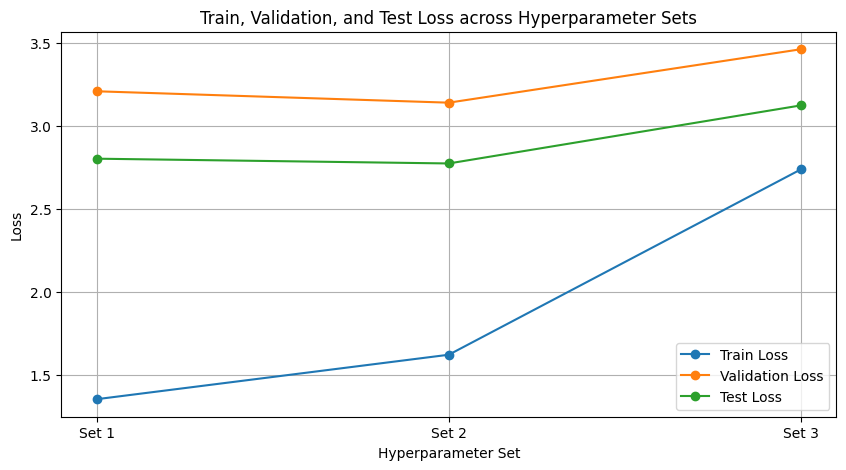

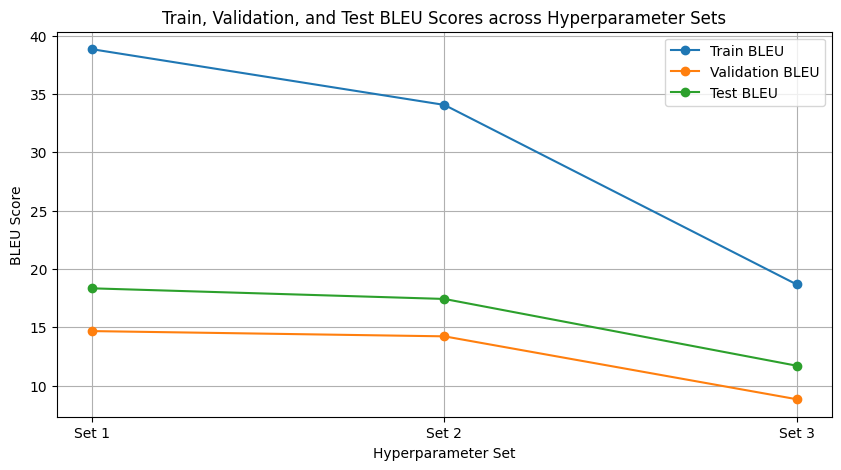

In [ ]:
import matplotlib.pyplot as plt

# Data
hyperparameter_labels = ['Set 1', 'Set 2', 'Set 3']
train_losses = [1.3566, 1.6242, 2.7396]
valid_losses = [3.2089, 3.1403, 3.4618]
test_losses = [2.8034, 2.7747, 3.1241]

train_bleus = [38.8266, 34.0552, 18.6776]
valid_bleus = [14.6802, 14.2309, 8.8439]
test_bleus = [18.3437, 17.4338, 11.7142]

# Plotting Losses
plt.figure(figsize=(10, 5))
plt.plot(hyperparameter_labels, train_losses, label='Train Loss', marker='o')
plt.plot(hyperparameter_labels, valid_losses, label='Validation Loss', marker='o')
plt.plot(hyperparameter_labels, test_losses, label='Test Loss', marker='o')
plt.xlabel('Hyperparameter Set')
plt.ylabel('Loss')
plt.title('Train, Validation, and Test Loss across Hyperparameter Sets')
plt.legend()
plt.grid(True)
plt.show()

# Plotting BLEU Scores
plt.figure(figsize=(10, 5))
plt.plot(hyperparameter_labels, train_bleus, label='Train BLEU', marker='o')
plt.plot(hyperparameter_labels, valid_bleus, label='Validation BLEU', marker='o')
plt.plot(hyperparameter_labels, test_bleus, label='Test BLEU', marker='o')
plt.xlabel('Hyperparameter Set')
plt.ylabel('BLEU Score')
plt.title('Train, Validation, and Test BLEU Scores across Hyperparameter Sets')
plt.legend()
plt.grid(True)
plt.show()